## Data Harmonization

In [2]:
import pandas as pd
import numpy as np

def harmonize_exoplanet_data():
    """
    Loads and harmonizes exoplanet data from Kepler, K2, and TESS missions.

    This function performs the following steps:
    1. Defines the file paths for the three NASA datasets.
    2. [cite_start]Specifies column and label mapping schemas based on the project document[cite: 73, 74].
    3. Loads each dataset, renames columns, and standardizes the target labels.
    4. Adds a 'source' column to track the origin of each data point.
    5. Concatenates the three datasets into a single master DataFrame.
    6. Performs final cleaning by dropping rows with unmapped target labels.
    7. Prints a summary of the final harmonized dataset.

    Returns:
        pandas.DataFrame: A single DataFrame containing the combined and
                          harmonized data from all three missions.
    """
    # --- 1. Define File Paths and Schemas ---
    # NOTE: Replace these with the actual paths to your downloaded CSV files.
    KEPLER_PATH = 'Kepler Objects of Interest (KOI).csv'
    K2_PATH = 'K2 Planets and Candidates.csv'
    TESS_PATH = 'TESS Objects of Interest (TOI).csv'

    # [cite_start]Define the unified column mapping based on Table 1 of the project document[cite: 73, 74].
    UNIFIED_SCHEMA = {
        # Unified Name: [Kepler Name, K2 Name, TESS Name]
        'target_disposition': ['koi_disposition', 'disposition', 'tfopwg_disp'],
        'fp_flag_nt': ['koi_fpflag_nt', None, None],
        'fp_flag_ss': ['koi_fpflag_ss', None, None],
        'fp_flag_co': ['koi_fpflag_co', None, None],
        'fp_flag_ec': ['koi_fpflag_ec', None, None],
        'orbital_period_days': ['koi_period', 'pl_orbper', 'pl_orbper'],
        'transit_epoch_bjd': ['koi_time0bk', 'pl_tranmid', 'pl_tranmid'],
        'transit_duration_hr': ['koi_duration', 'pl_trandur', 'pl_trandurh'],
        'transit_depth_ppm': ['koi_depth', 'pl_trandep', 'pl_trandep'],
        'planet_radius_earth': ['koi_prad', 'pl_rade', 'pl_rade'],
        'equilibrium_temp_k': ['koi_teq', 'pl_eqt', 'pl_eqt'],
        'insolation_flux_earth': ['koi_insol', 'pl_insol', 'pl_insol'],
        'impact_parameter': ['koi_impact', 'pl_imppar', None],
        'stellar_eff_temp_k': ['koi_steff', 'st_teff', 'st_teff'],
        'stellar_logg_cm_s2': ['koi_slogg', 'st_logg', 'st_logg'],
        'stellar_radius_solar': ['koi_srad', 'st_rad', 'st_rad']
    }
    
    # Create reverse mappings for each source for easy renaming
    kepler_map = {v[0]: k for k, v in UNIFIED_SCHEMA.items() if v[0] is not None}
    k2_map = {v[1]: k for k, v in UNIFIED_SCHEMA.items() if v[1] is not None}
    tess_map = {v[2]: k for k, v in UNIFIED_SCHEMA.items() if v[2] is not None}
    
    final_columns = list(UNIFIED_SCHEMA.keys())

    # [cite_start]Define the mapping for the target disposition labels[cite: 46, 51, 52, 54].
    LABEL_MAP = {
        'CONFIRMED': 'CONFIRMED',
        'CANDIDATE': 'CANDIDATE',
        'PC': 'CANDIDATE',        # TESS Planet Candidate
        'FALSE POSITIVE': 'FALSE POSITIVE',
        'FP': 'FALSE POSITIVE'    # TESS False Positive
    }

    # --- 2. Load and Process Datasets ---
    print("Starting data harmonization process...")

    # Load Kepler Data
    # The NASA CSVs often have commented metadata at the top, which we can skip.
    df_kepler = pd.read_csv(KEPLER_PATH, comment='#', low_memory=False)
    df_kepler.rename(columns=kepler_map, inplace=True)
    df_kepler['source'] = 'Kepler'

    # Load K2 Data
    df_k2 = pd.read_csv(K2_PATH, comment='#', low_memory=False)
    df_k2.rename(columns=k2_map, inplace=True)
    df_k2['source'] = 'K2'
    
    # Load TESS Data
    df_tess = pd.read_csv(TESS_PATH, comment='#', low_memory=False)
    df_tess.rename(columns=tess_map, inplace=True)
    df_tess['source'] = 'TESS'

    # --- 3. Combine and Standardize ---
    # Concatenate all dataframes into one
    df_harmonized = pd.concat([df_kepler, df_k2, df_tess], ignore_index=True, sort=False)
    
    # Standardize the target disposition column using the defined map
    df_harmonized['target_disposition'] = df_harmonized['target_disposition'].map(LABEL_MAP)

    # Filter the DataFrame to keep only the unified columns and the source identifier
    df_final = df_harmonized[final_columns + ['source']].copy()

    # Drop any rows where the disposition is now null (e.g., from TESS 'APC' or 'KP' which we chose to ignore)
    df_final.dropna(subset=['target_disposition'], inplace=True)
    
    print("✓ Data harmonization complete.")
    
    # --- 4. Display Results ---
    print("\n--- Summary of Harmonized Dataset ---")
    print(f"Shape of the final dataset: {df_final.shape}")
    print("\nDistribution of Target Classes:")
    print(df_final['target_disposition'].value_counts())
    print("\nDistribution of Data Sources:")
    print(df_final['source'].value_counts())
    print("\nFirst 5 rows:")
    print(df_final.head())
    print("\nMissing values for False Positive flags (as expected):")
    print(df_final[['fp_flag_nt', 'fp_flag_ss', 'fp_flag_co', 'fp_flag_ec', 'source']].groupby('source').apply(lambda x: x.isnull().sum()))


    return df_final

# Execute the function
if __name__ == '__main__':
    # Make sure you have the CSV files in the same directory as this script,
    # or update the file paths at the top of the function.
    try:
        harmonized_df = harmonize_exoplanet_data()
        # You can now save this harmonized dataframe to a new CSV for the next step
        harmonized_df.to_csv('harmonized_exoplanet_data.csv', index=False)
        print("\nSuccessfully saved harmonized data to 'harmonized_exoplanet_data.csv'")
    except FileNotFoundError as e:
        print(f"\nError: {e}")
        print("Please make sure the NASA exoplanet CSV files are downloaded and in the correct path.")

Starting data harmonization process...
✓ Data harmonization complete.

--- Summary of Harmonized Dataset ---
Shape of the final dataset: (19420, 17)

Distribution of Target Classes:
target_disposition
CANDIDATE         8031
FALSE POSITIVE    6328
CONFIRMED         5061
Name: count, dtype: int64

Distribution of Data Sources:
source
Kepler    9564
TESS      5874
K2        3982
Name: count, dtype: int64

First 5 rows:
  target_disposition  fp_flag_nt  fp_flag_ss  fp_flag_co  fp_flag_ec  \
0          CONFIRMED         0.0         0.0         0.0         0.0   
1          CONFIRMED         0.0         0.0         0.0         0.0   
2          CANDIDATE         0.0         0.0         0.0         0.0   
3     FALSE POSITIVE         0.0         1.0         0.0         0.0   
4          CONFIRMED         0.0         0.0         0.0         0.0   

   orbital_period_days  transit_epoch_bjd  transit_duration_hr  \
0             9.488036         170.538750              2.95750   
1            54

C:\Users\vibha\AppData\Local\Temp\ipykernel_11332\1793909452.py:108: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_final[['fp_flag_nt', 'fp_flag_ss', 'fp_flag_co', 'fp_flag_ec', 'source']].groupby('source').apply(lambda x: x.isnull().sum()))



Successfully saved harmonized data to 'harmonized_exoplanet_data.csv'


## Data Cleaning and Imputation

Loaded harmonized dataset with shape: (19420, 17)
Total missing values before imputation: 66504

Visualizing missing data pattern before imputation...


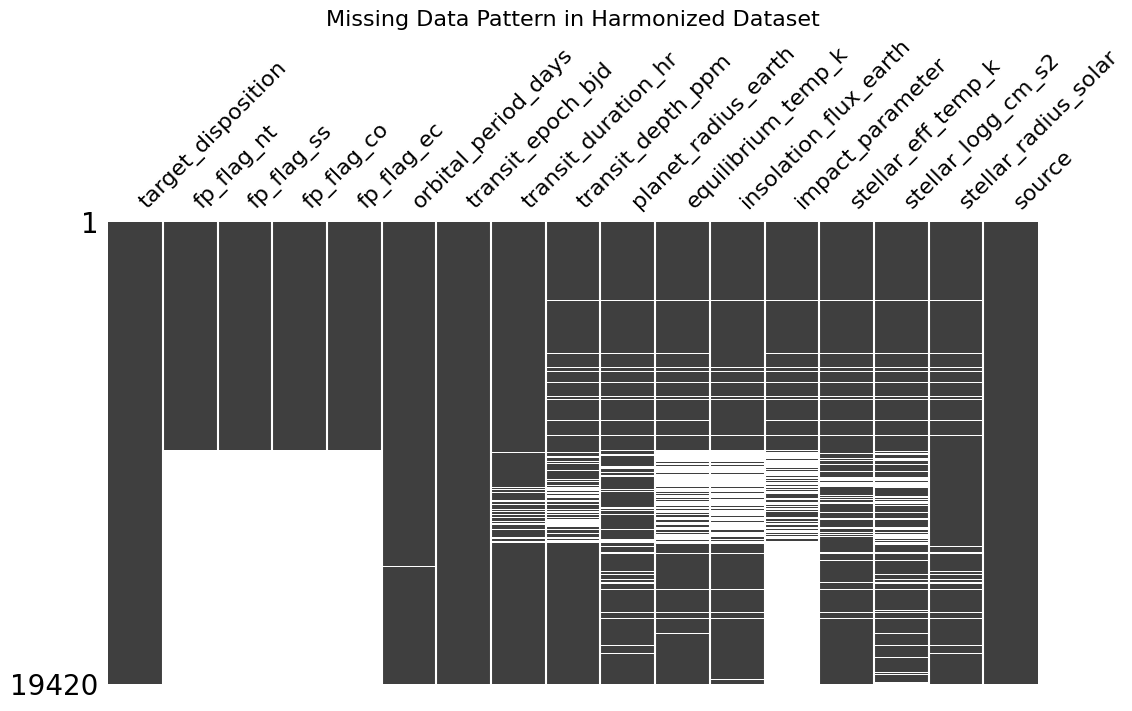


Performing imputation using IterativeImputer...
[IterativeImputer] Completing matrix with shape (19420, 15)
[IterativeImputer] Change: 1011999.3305448806, scaled tolerance: 10947.55455 
[IterativeImputer] Change: 95754.84343038294, scaled tolerance: 10947.55455 
[IterativeImputer] Change: 11624.493491640169, scaled tolerance: 10947.55455 
[IterativeImputer] Change: 6296.682797683459, scaled tolerance: 10947.55455 
[IterativeImputer] Early stopping criterion reached.

✓ Imputation complete.

--- Summary of Imputed Dataset ---
Total missing values after imputation: 0
Successfully imputed all missing values.

First 5 rows of the complete dataset:
   fp_flag_nt  fp_flag_ss  fp_flag_co  fp_flag_ec  orbital_period_days  \
0         0.0         0.0         0.0         0.0             9.488036   
1         0.0         0.0         0.0         0.0            54.418383   
2         0.0         0.0         0.0         0.0            19.899140   
3         0.0         1.0         0.0         0.0  

In [3]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import missingno as msno
import matplotlib.pyplot as plt

def impute_missing_data(filepath='harmonized_exoplanet_data.csv'):
    """
    Loads the harmonized dataset and imputes missing values using IterativeImputer.

    This function performs the following steps:
    1. Loads the harmonized data.
    2. Visualizes the pattern of missing data before imputation.
    3. Separates features from metadata/target columns.
    4. [cite_start]Uses IterativeImputer to predict and fill missing values based on other features[cite: 130].
    5. Reconstructs the full DataFrame with the imputed values.
    6. Verifies that no missing values remain.
    7. Saves the complete, imputed dataset to a new CSV file.

    Args:
        filepath (str): The path to the harmonized CSV file.

    Returns:
        pandas.DataFrame: A fully imputed DataFrame with no missing values.
    """
    # --- 1. Load Harmonized Data ---
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure you have run the previous step successfully.")
        return None

    print(f"Loaded harmonized dataset with shape: {df.shape}")
    print(f"Total missing values before imputation: {df.isnull().sum().sum()}")

    # --- 2. Analyze Missingness Pattern ---
    # [cite_start]The missingno library provides a clear visualization of where data is missing[cite: 125].
    print("\nVisualizing missing data pattern before imputation...")
    msno.matrix(df, figsize=(12, 6), sparkline=False)
    plt.title('Missing Data Pattern in Harmonized Dataset', fontsize=16)
    plt.show()

    # --- 3. Prepare Data for Imputation ---
    # The imputer should only run on numerical feature columns.
    # We'll separate the target and source columns and add them back later.
    target_col = df['target_disposition']
    source_col = df['source']
    features_df = df.drop(columns=['target_disposition', 'source'])
    # Store column order to reconstruct the DataFrame correctly
    original_cols = features_df.columns.tolist()

    # --- 4. Perform Model-Based Imputation ---
    print("\nPerforming imputation using IterativeImputer...")
    # This technique models each feature with missing values as a function of
    # [cite_start]other features and uses that estimate for imputation[cite: 130].
    imputer = IterativeImputer(
        max_iter=10,        # The number of imputation rounds
        random_state=42,    # Ensures the results are reproducible
        verbose=1           # Shows the progress of each iteration
    )
    
    # The imputer returns a NumPy array, so we'll lose column names temporarily.
    features_imputed_array = imputer.fit_transform(features_df)
    print("\n✓ Imputation complete.")

    # --- 5. Reconstruct the DataFrame ---
    # Convert the imputed array back to a DataFrame, restoring the column names.
    df_imputed_features = pd.DataFrame(features_imputed_array, columns=original_cols)
    
    # Combine the imputed features with the target and source columns.
    df_complete = pd.concat([df_imputed_features, target_col, source_col], axis=1)

    # --- 6. Verify and Save the Result ---
    print("\n--- Summary of Imputed Dataset ---")
    missing_after = df_complete.isnull().sum().sum()
    print(f"Total missing values after imputation: {missing_after}")

    if missing_after == 0:
        print("Successfully imputed all missing values.")
        print("\nFirst 5 rows of the complete dataset:")
        print(df_complete.head())
        
        # Save the fully imputed DataFrame for the next step in the pipeline.
        output_filepath = 'imputed_exoplanet_data.csv'
        df_complete.to_csv(output_filepath, index=False)
        print(f"\nSuccessfully saved imputed data to '{output_filepath}'")
    else:
        print("\nWarning: Missing values still exist. Please check the pipeline.")
        
    return df_complete


# Execute the imputation function
if __name__ == '__main__':
    imputed_df = impute_missing_data()

##  Advanced Feature Engineering and Outlier Treatment

Loaded imputed dataset with shape: (19420, 17)

Starting feature engineering...
✓ Feature engineering complete. New shape: (19420, 19)
New features created: 'stellar_density', 'radius_ratio'

Applying winsorization to handle extreme outliers...
✓ Winsorization complete.

Visualizing the effect of winsorization on 'planet_radius_earth'...


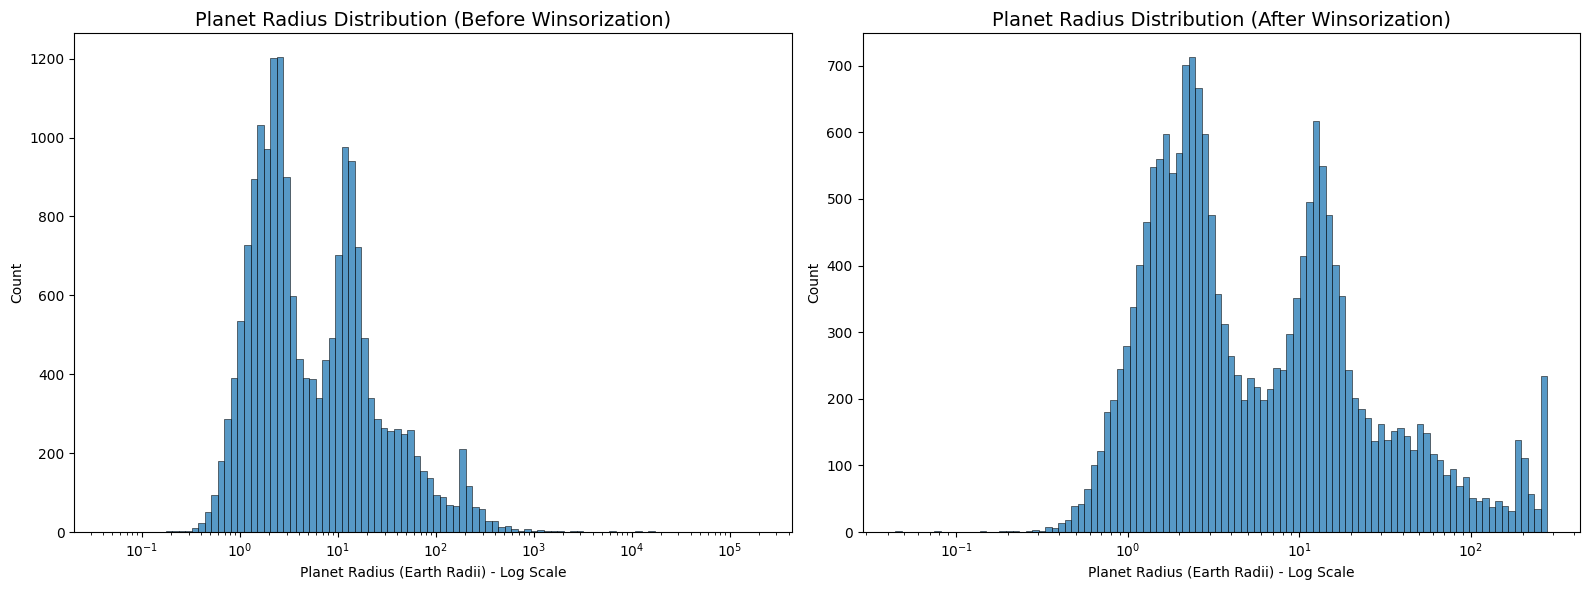


--- Descriptive Stats Comparison ---
Min/Max values before winsorization:
                                min           max
fp_flag_nt                 0.000000  9.877858e+02
fp_flag_ss              -744.468507  1.000000e+00
fp_flag_co               -44.870061  1.000000e+00
fp_flag_ec               -69.182010  1.000000e+00
orbital_period_days      -88.318634  1.299958e+05
transit_epoch_bjd        120.515914  2.460812e+06
transit_duration_hr       -0.068000  1.385400e+02
transit_depth_ppm     -41749.269174  1.541400e+06
planet_radius_earth     -479.474584  2.003460e+05
equilibrium_temp_k     -2107.551743  1.466700e+04
insolation_flux_earth -55950.247217  1.094755e+07
impact_parameter          -0.010000  1.008060e+02
stellar_eff_temp_k      2520.000000  5.000000e+04
stellar_logg_cm_s2        -0.295320  5.802760e+00
stellar_radius_solar      -2.523457  2.299080e+02
stellar_density          -19.017295  1.574875e+02
radius_ratio             -32.736384  9.998425e+01

Min/Max values after win

In [4]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

def feature_engineer_and_treat_outliers(filepath='imputed_exoplanet_data.csv'):
    """
    Loads the imputed dataset, engineers new features, and treats outliers.

    This function performs the following steps:
    1. Loads the imputed data.
    2. Creates two new features: 'stellar_density' and 'radius_ratio'.
    3. Winsorizes all numerical columns, capping extreme values at the 1st
       and 99th percentiles to mitigate the effect of outliers.
    4. Visualizes the effect of winsorization on a key feature distribution.
    5. Compares descriptive statistics before and after treatment.
    6. Saves the final processed dataset to a new CSV file.

    Args:
        filepath (str): The path to the imputed CSV file.

    Returns:
        pandas.DataFrame: A DataFrame with new features and treated outliers.
    """
    # --- 1. Load Imputed Data ---
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure you have run the previous step successfully.")
        return None

    print(f"Loaded imputed dataset with shape: {df.shape}")

    # --- 2. Advanced Feature Engineering ---
    print("\nStarting feature engineering...")
    
    # a) Calculate Stellar Density
    # This feature relates to the transit shape and duration.
    # We estimate stellar mass (M) from stellar radius (R) and surface gravity (g),
    # then calculate density (rho ~ M/R^3).
    G = 6.67430e-11          # Gravitational constant (m^3 kg^-1 s^-2)
    R_sun_m = 6.957e8        # Solar radius (m)
    M_sun_kg = 1.989e30      # Solar mass (kg)
    
    R_star_m = df['stellar_radius_solar'] * R_sun_m
    g_star_ms2 = (10**df['stellar_logg_cm_s2']) / 100  # Convert logg to m/s^2
    M_star_kg = (g_star_ms2 * R_star_m**2) / G
    M_star_solar = M_star_kg / M_sun_kg
    
    # Adding a small epsilon to avoid division by zero
    df['stellar_density'] = M_star_solar / (df['stellar_radius_solar']**3 + 1e-9)

    # b) Calculate Planet-Star Radius Ratio
    # This is directly related to the transit depth.
    R_sun_to_R_earth = 109.076
    stellar_radius_earth = df['stellar_radius_solar'] * R_sun_to_R_earth
    df['radius_ratio'] = df['planet_radius_earth'] / (stellar_radius_earth + 1e-9)

    print(f"✓ Feature engineering complete. New shape: {df.shape}")
    print("New features created: 'stellar_density', 'radius_ratio'")

    # --- 3. Outlier Treatment with Winsorization ---
    # This process caps extreme values to prevent them from skewing the model.
    print("\nApplying winsorization to handle extreme outliers...")
    
    df_featured = df.copy()
    numerical_cols = df_featured.select_dtypes(include=np.number).columns

    for col in numerical_cols:
        # Cap values at the 1st and 99th percentiles
        df_featured[col] = winsorize(df_featured[col], limits=[0.01, 0.01])
        
    print("✓ Winsorization complete.")

    # --- 4. Verify and Visualize the Effect ---
    print("\nVisualizing the effect of winsorization on 'planet_radius_earth'...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.histplot(data=df, x='planet_radius_earth', bins=100, log_scale=True, ax=axes[0])
    axes[0].set_title('Planet Radius Distribution (Before Winsorization)', fontsize=14)
    axes[0].set_xlabel('Planet Radius (Earth Radii) - Log Scale')
    
    sns.histplot(data=df_featured, x='planet_radius_earth', bins=100, log_scale=True, ax=axes[1])
    axes[1].set_title('Planet Radius Distribution (After Winsorization)', fontsize=14)
    axes[1].set_xlabel('Planet Radius (Earth Radii) - Log Scale')
    plt.tight_layout()
    plt.show()

    print("\n--- Descriptive Stats Comparison ---")
    print("Min/Max values before winsorization:")
    print(df[numerical_cols].agg(['min', 'max']).T)
    print("\nMin/Max values after winsorization:")
    print(df_featured[numerical_cols].agg(['min', 'max']).T)

    # --- 5. Save the Result ---
    output_filepath = 'featured_exoplanet_data.csv'
    df_featured.to_csv(output_filepath, index=False)
    print(f"\nSuccessfully saved feature-engineered data to '{output_filepath}'")

    return df_featured

# Execute the function
if __name__ == '__main__':
    featured_df = feature_engineer_and_treat_outliers()

## Feature Scaling and Class Balancing

Loaded featured dataset with shape: (19420, 19)

Target labels encoded:
- CANDIDATE: 0
- CONFIRMED: 1
- FALSE POSITIVE: 2


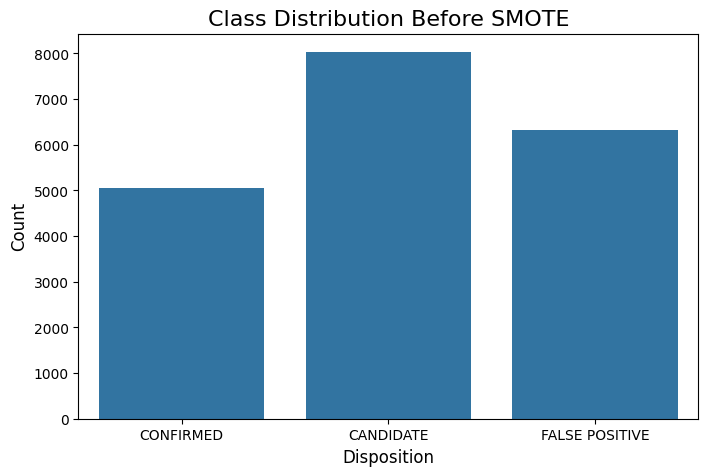


Class distribution before SMOTE:
target_disposition
CANDIDATE         8031
FALSE POSITIVE    6328
CONFIRMED         5061
Name: count, dtype: int64

Applying StandardScaler to features...
✓ Features scaled successfully.

Applying SMOTE to balance classes...
✓ SMOTE applied successfully.

Shape of features before SMOTE: (19420, 17)
Shape of features after SMOTE: (24093, 17)


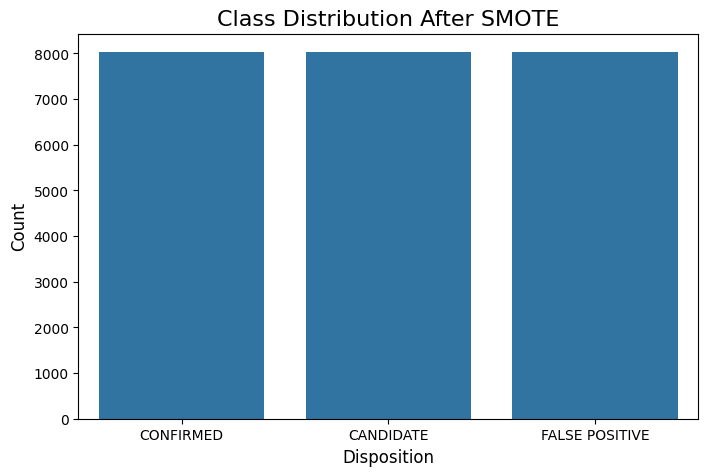


Class distribution after SMOTE:
CONFIRMED         8031
CANDIDATE         8031
FALSE POSITIVE    8031
Name: count, dtype: int64

Successfully saved final processed data to 'X_processed.csv' and 'y_processed.csv'


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

def scale_and_balance_data(filepath='featured_exoplanet_data.csv'):
    """
    Loads the feature-engineered dataset, scales numerical features, and
    balances the target classes using SMOTE.

    This function performs the following steps:
    1. Loads the feature-engineered and outlier-treated data.
    2. Separates features (X) from the target variable (y).
    3. Encodes the categorical target variable into numerical labels.
    4. Visualizes the class imbalance before balancing.
    5. Applies StandardScaler to normalize the feature data.
    6. Applies SMOTE to oversample the minority classes.
    7. Visualizes the balanced class distribution.
    8. Saves the final, processed X and y dataframes for model training.

    Args:
        filepath (str): The path to the featured CSV file.

    Returns:
        tuple: A tuple containing the processed features (X_resampled) and
               target (y_resampled) as pandas DataFrames.
    """
    # --- 1. Load Featured Data ---
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure you have run the previous step successfully.")
        return None, None

    print(f"Loaded featured dataset with shape: {df.shape}")

    # --- 2. Prepare Data for Scaling and Balancing ---
    # Separate features (X) and target (y).
    # The 'source' column is metadata, not a predictive feature, so we drop it.
    X = df.drop(columns=['target_disposition', 'source'])
    y = df['target_disposition']
    
    # Encode the categorical target variable (e.g., 'CONFIRMED' -> 0)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print("\nTarget labels encoded:")
    for i, class_name in enumerate(le.classes_):
        print(f"- {class_name}: {i}")

    # --- 3. Visualize Class Imbalance ---
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y)
    plt.title('Class Distribution Before SMOTE', fontsize=16)
    plt.xlabel('Disposition', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()
    print("\nClass distribution before SMOTE:")
    print(y.value_counts())

    # --- 4. Apply Feature Scaling ---
    print("\nApplying StandardScaler to features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("✓ Features scaled successfully.")

    # --- 5. Apply SMOTE for Class Balancing ---
    print("\nApplying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_resampled_np, y_resampled_np = smote.fit_resample(X_scaled, y_encoded)
    print("✓ SMOTE applied successfully.")

    # --- 6. Verify and Visualize Balanced Data ---
    print("\nShape of features before SMOTE:", X_scaled.shape)
    print("Shape of features after SMOTE:", X_resampled_np.shape)
    
    # Convert resampled data back to a readable format
    y_resampled_decoded = le.inverse_transform(y_resampled_np)
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_resampled_decoded)
    plt.title('Class Distribution After SMOTE', fontsize=16)
    plt.xlabel('Disposition', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_resampled_decoded).value_counts())

    # --- 7. Save Final Processed Data ---
    # Convert final arrays to DataFrames for saving
    X_processed = pd.DataFrame(X_resampled_np, columns=X.columns)
    y_processed = pd.DataFrame(y_resampled_np, columns=['target_disposition_encoded'])

    X_processed.to_csv('X_processed.csv', index=False)
    y_processed.to_csv('y_processed.csv', index=False)
    print("\nSuccessfully saved final processed data to 'X_processed.csv' and 'y_processed.csv'")
    
    return X_processed, y_processed

# Execute the function
if __name__ == '__main__':
    X_final, y_final = scale_and_balance_data()

## Model Training and Evaluation

Loaded processed data.
Data split into 19274 training samples and 4819 test samples.

Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

Evaluating model performance on the test set...

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.81      0.81      0.81      1606
     CONFIRMED       0.86      0.92      0.89      1606
FALSE POSITIVE       0.95      0.89      0.91      1607

      accuracy                           0.87      4819
     macro avg       0.87      0.87      0.87      4819
  weighted avg       0.87      0.87      0.87      4819



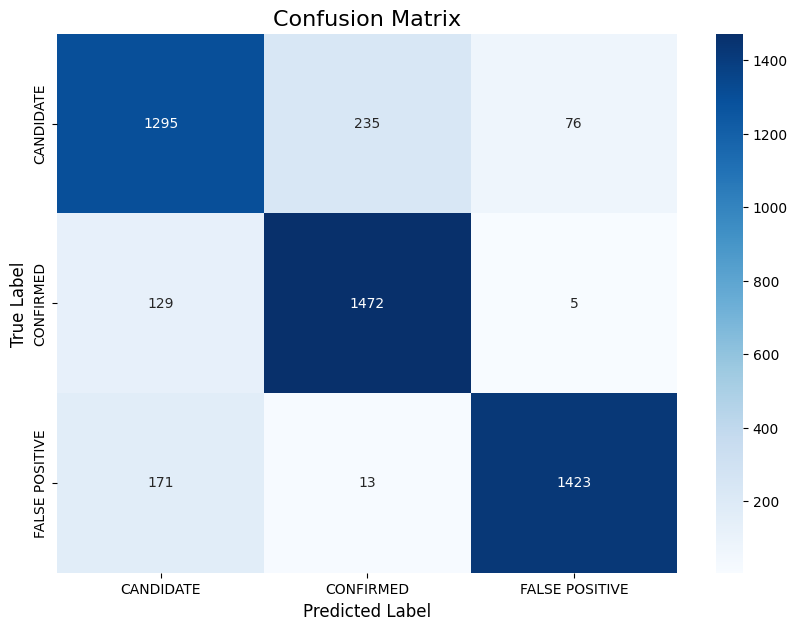


Top 10 Most Important Features:
                feature  importance
1            fp_flag_ss    0.127172
0            fp_flag_nt    0.111618
2            fp_flag_co    0.105246
8   planet_radius_earth    0.081126
5     transit_epoch_bjd    0.076088
7     transit_depth_ppm    0.066472
3            fp_flag_ec    0.060040
16         radius_ratio    0.058266
4   orbital_period_days    0.057723
9    equilibrium_temp_k    0.042241


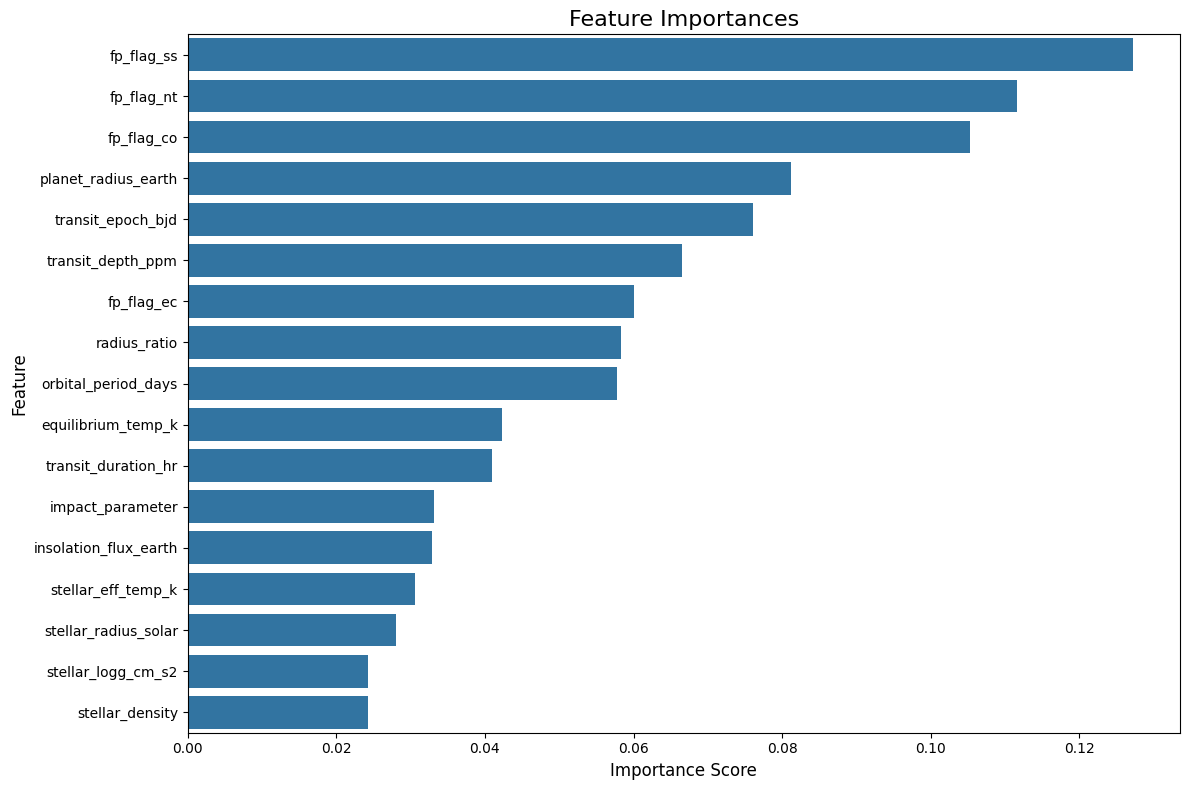


✓ Final trained model saved to 'exoplanet_rf_model.joblib'
✓ Scaler fitted on all data saved to 'scaler.joblib'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

def train_and_evaluate_model(X_path='X_processed.csv', y_path='y_processed.csv'):
    """
    Loads processed data, trains a Random Forest model with hyperparameter
    tuning, evaluates its performance, and saves the final model.
    """
    # --- 1. Load Processed Data ---
    try:
        X = pd.read_csv(X_path)
        y = pd.read_csv(y_path).squeeze() # Use squeeze to convert to a Series
    except FileNotFoundError:
        print(f"Error: Make sure '{X_path}' and '{y_path}' exist.")
        return

    # For decoding labels later. Assumes 0:CANDIDATE, 1:CONFIRMED, 2:FALSE POSITIVE
    # This order may change based on your LabelEncoder run, adjust if needed.
    class_names = ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'] 
    print("Loaded processed data.")

    # --- 2. Split Data into Training and Test Sets ---
    # Using stratification to maintain the same class proportion in train/test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Data split into {len(X_train)} training samples and {len(X_test)} test samples.")

    # --- 3. Hyperparameter Tuning with GridSearchCV ---
    print("\nStarting hyperparameter tuning with GridSearchCV...")
    param_grid = {
        'n_estimators': [100, 200],         # Number of trees in the forest
        'max_depth': [10, 20, None],        # Max depth of the trees
        'min_samples_leaf': [1, 2, 4],      # Min samples required at a leaf node
        'max_features': ['sqrt', 'log2']    # Number of features to consider for best split
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')
    
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters found:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    # --- 4. Evaluate the Model on the Test Set ---
    print("\nEvaluating model performance on the test set...")
    y_pred = best_model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # --- 5. Visualize the Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    # --- 6. Analyze Feature Importances ---
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # --- 7. Save the Final Model ---
    model_filename = 'exoplanet_rf_model.joblib'
    joblib.dump(best_model, model_filename)
    print(f"\n✓ Final trained model saved to '{model_filename}'")
    # Also save the scaler, it's needed for predictions on new data
    # We need to refit it on the full training X before saving
    from sklearn.preprocessing import StandardScaler
    final_scaler = StandardScaler().fit(X) 
    scaler_filename = 'scaler.joblib'
    joblib.dump(final_scaler, scaler_filename)
    print(f"✓ Scaler fitted on all data saved to '{scaler_filename}'")


if __name__ == '__main__':
    train_and_evaluate_model()

## Prepare a Data Sample for the Frontend

In [1]:
import pandas as pd

# Load the original harmonized (but not scaled/balanced) data
df_harmonized = pd.read_csv('harmonized_exoplanet_data.csv')

# Select only the columns needed for the plot
df_plot_data = df_harmonized[['orbital_period_days', 'planet_radius_earth', 'target_disposition']].copy()

# Drop rows with missing values in these specific columns
df_plot_data.dropna(inplace=True)

# Create a smaller, random sample of 2000 points
df_sample = df_plot_data.sample(n=2000, random_state=42)

# Save the sample to the frontend's public directory as JSON
# Make sure the path is correct for your project structure
output_path = 'C:\\Users\\vibha\\OneDrive\\Desktop\\NASA\\frontend\\public\\training_data_sample.json'
df_sample.to_json(output_path, orient='records')

print(f"Successfully saved a {len(df_sample)}-row sample to '{output_path}'")

Successfully saved a 2000-row sample to 'C:\Users\vibha\OneDrive\Desktop\NASA\frontend\public\training_data_sample.json'
